In [0]:
# install tensorboard
pip install tensorboardcolab

In [0]:
# !pip install tensorflow==2.0.0


In [0]:
# pip install -U keras

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')
model_name = 'final_vae_10snr_1_6' #set model name
#make a directory Colab Notebooks/camera_ready_runs/model_name so the weights would be saved there
directory_path = 'gdrive/My Drive/Colab Notebooks/camera_ready_runs/' + model_name
weights_path = directory_path + '/' + model_name + '_weights_' # change to the address you want to save if needed

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.path.isdir(directory_path)

True

In [0]:
# imports
import numpy as np
from tensorboardcolab import *
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import backend as K 
from keras.layers import Layer, PReLU, Conv2D, Activation, Conv2DTranspose , GaussianNoise,BatchNormalization,Conv1D
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math

In [0]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
# Divide data into test and validdation
X_test, X_validation, Y_test,Y_validation  = train_test_split(X_test, Y_test, test_size=0.33, random_state=42)


In [0]:
# Normalizing dataset
X_train_norm = X_train/255
X_test_norm = X_test/255
X_validation_norm = X_validation/255


In [108]:
k = 8*8*16
n = 32*32*3
sqrtk = np.sqrt(k)
c = k//64
snr = 10  #set SENR here
p = 1
std = np.sqrt(p / math.pow(10, snr/10))
width = 32
height = 32
batch_size = 64
nb_epochs = 150
print(std, 'K/N:', k/(n*2))

0.31622776601683794 K/N: 0.16666666666666666


In [0]:
# imports
import numpy as np
from tensorboardcolab import *
from keras.models import Model
from keras.layers import Layer, PReLU, Conv2D, Activation, Conv2DTranspose , GaussianNoise,Lambda, Flatten, Reshape,BatchNormalization,Reshape
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import backend as K 
import math

In [0]:
from keras.layers import Input, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D, Flatten
#from keras.mode import Model
#encoder part
input = Input(shape=(32,32,3))
conv_1 = Conv2D(16,(5,5),padding = 'same', strides = 2,activation='relu')(input)
conv_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32,(5,5),padding = 'same', strides = 2,activation='relu')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_3 = Conv2D(32,(5,5),padding = 'same', strides = 1,activation='relu')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_4 = Conv2D(32,(5,5),padding = 'same', strides = 1,activation='relu')(conv_3)
conv_4 = BatchNormalization()(conv_4)
encoded = Conv2D(c,(5,5),padding = 'same', strides = 1,activation='relu')(conv_4)


z_mean = Conv2D(c,(5,5),padding = 'same', strides = 1,activation='relu')(encoded)
z_log_var = Conv2D(c,(5,5),padding = 'same', strides = 1,activation='relu')(encoded)


In [0]:
#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],K.shape(z_mean)[1],K.shape(z_mean)[2],K.shape(z_mean)[3]), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon


In [0]:
from keras.layers import Input, Dense, Lambda,Reshape, Flatten
z = Lambda(sampling, output_shape=(8,8,c))([z_mean, z_log_var])
z = Flatten()(z)

In [0]:
class ChannelNormalizer(Layer):

  def __init__(self,sqrtk, **kwargs):
#     self.output_dim = output_dim
    self.sqrtk=sqrtk
    super(ChannelNormalizer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(ChannelNormalizer, self).build(input_shape)  # Be sure to call this at the end

  def call(self, x):
    #return self.sqrtk*K.l2_normalize(x,axis=1)
       #return self.sqrtk*x/tf.sqrt(tf.transpose(x, conjugate=True,perm=[0,1])*x) 
       return x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  def compute_output_shape(self, input_shape):
    return input_shape

In [0]:
z = ChannelNormalizer(sqrtk, name='normal')(z)

In [0]:
class ChannelNoise(Layer):

  def __init__(self, sigma, **kwargs):
    self.sigma = sigma
    super(ChannelNoise, self).__init__(**kwargs)

  def build(self, input_shape):
    self.inshape = input_shape
    super(ChannelNoise, self).build(input_shape)

  def call(self, x):
    return x + K.random_normal(self.inshape[1:], mean = 0, stddev = self.sigma)

  def compute_output_shape(self, input_shape):
    return input_shape

z = ChannelNoise(std)(z)     

In [0]:
#decoder part
z = Reshape([8,8,c])(z)
conv_0T = Conv2DTranspose(32,(5,5), padding = 'same', strides = 1,activation='relu')(z)
conv_0T = BatchNormalization()(conv_0T)
conv_1T = Conv2DTranspose(32,(5,5), padding = 'same', strides = 1,activation='relu')(conv_0T)
conv_1T = BatchNormalization()(conv_1T)
conv_2T = Conv2DTranspose(32,(5,5), padding = 'same', strides = 1,activation='relu')(conv_1T)
conv_2T = BatchNormalization()(conv_2T)
conv_3T = Conv2DTranspose(16,(5,5), padding = 'same', strides = 2,activation='relu')(conv_2T)
conv_3T = BatchNormalization()(conv_3T)
x_out = Conv2DTranspose(3,(5,5), padding = 'same', strides = 2,activation='sigmoid')(conv_3T)

In [0]:
vae = Model(input, x_out)
# vae.summary()

In [0]:
from keras import metrics
def VAE_loss(x_origin,x_out):
    kl_tolerance = 2
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x_origin- x_out), axis=[1, 2, 3]))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * (32*32*3)))
    loss_sum = reconstruction_loss + kl_loss
    return loss_sum


def PSNR(y_true,y_pred):
  return 10 * K.log(K.max(y_true)**2 / (K.mean(K.square(y_pred-y_true)))) / K.log(10.0)    

def schedule(epoch, lr):
  lr=0.001

  if epoch > 2000:
    lr=float(0.0000001)
  elif epoch > 200:
    lr=float(0.000001)
  elif epoch > 50:
    lr=float(0.00001)
  elif epoch > 10:
    lr=float(0.0001)
  
  
  
  return lr
lrate = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
chckpnt = keras.callbacks.callbacks.ModelCheckpoint(directory_path+'/weights.{epoch}-{val_PSNR:.2f}.h5', monitor='val_PSNR', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
csv = keras.callbacks.callbacks.CSVLogger(directory_path+'/logs.log', separator=',', append=True)
opt = keras.optimizers.Adam(lr=0.001, clipvalue=1)

vae.compile(optimizer=opt, loss=VAE_loss,metrics=[PSNR])
passed_epoches = 0

In [43]:
opt.learning_rate.assign(0.1)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.1>

In [0]:
ep = []
psnrs = []

In [0]:
#load weights if needed
vae.load_weights(directory_path+'/weights.6-20.90.h5') #set loading number here
passed_epoches = 0 #set this number before running this cell

In [119]:
for i in range(2):
  print('passed:', passed_epoches)
  vae.fit(X_train_norm,X_train_norm,shuffle=True,epochs=11 ,batch_size=64,validation_data=(X_validation_norm, X_validation_norm),callbacks=[lrate, chckpnt, csv])
  passed_epoches += 1
  vae.save_weights(weights_path+str(passed_epoches)+'.h5')
  ep.append(passed_epoches)
  psnrs.append(vae.evaluate(X_validation_norm,X_validation_norm)[1])


passed: 0
Train on 50000 samples, validate on 3300 samples
Epoch 1/11

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
50000/50000 [==============================] - 21s 429us/step - loss: 6192.3718 - PSNR: 18.6193 - val_loss: 6174.9832 - val_PSNR: 19.9793
Epoch 2/11

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
50000/50000 [==============================] - 19s 389us/step - loss: 6168.6322 - PSNR: 20.9989 - val_loss: 6167.5315 - val_PSNR: 21.2176
Epoch 3/11

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
50000/50000 [==============================] - 19s 389us/step - loss: 6163.0998 - PSNR: 22.0792 - val_loss: 6161.7714 - val_PSNR: 22.3845
Epoch 4/11

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
 5696/50000 [==>...........................] - ETA: 16s - loss: 6162.5961 - PSNR: 22.2013

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
plt.plot(ep, psnrs)
plt.show()

In [122]:
vae.evaluate(X_test_norm,X_test_norm)

6700/6700 [==============================] - 1s 215us/step


[6190.136353486474, 18.243974685668945]

In [32]:
math.sqrt(sum(np.sum(K.get_value(w)) for w in vae.optimizer.weights))

100.35917819310907

(98304,)

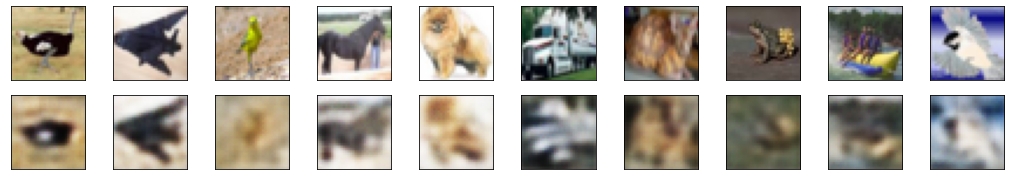

In [0]:
import matplotlib.pyplot as plt

t = vae.predict(X_test_norm[:32])

fig, ax = plt.subplots(2, 10, figsize=(18, 3))

for y in range(10):
    ax[0, y].get_xaxis().set_visible(False)
    ax[0, y].get_yaxis().set_visible(False)
    ax[1, y].get_xaxis().set_visible(False)
    ax[1, y].get_yaxis().set_visible(False)

    ax[0, y].imshow(X_test_norm[y])
    ax[1, y].imshow(t[y])
# plt.imshow(X_test_norm[1])
# plt.imshow(t[1])
t[t!=1].shape

In [0]:
#to test the normalizer
from keras.models import Model

m = Model(inputs=vae.input, outputs=vae.get_layer('normal').output)
f = m.predict(X_test_norm)
s = []
for i in f:
  s.append(np.sum(np.square(i)))

print(np.mean(s), k/2)

512.0 512.0
